In [1]:
import ccxt
import pandas as pd
import os
import ta
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# 初始化Binance交易所
exchange = ccxt.binance()

# 定義我們需要的數據對象
symbol = 'BTC/USDT'
timeframe = '1d'
starttime = '2022-01-01T00:00:00Z'
leverage = 100
use_macd = True
use_sar = False
use_rsi = False
fee = 0.015

#儲存檔案位置
path = 'data'
data_file = os.path.join(path, 'BTC2USDT.csv')

# 獲取歷史數據
def get_historical_data(symbol, timeframe, since):
    all_ohlcv = []
    while since < exchange.milliseconds():
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=1000)
        if not ohlcv:
            break
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        since = ohlcv[-1][0] + 1
        all_ohlcv.append(df)
    df = pd.concat(all_ohlcv)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

# 更新數據
def update_data(df, symbol, timeframe):
    last_timestamp = df.index[-1]
    since = int(last_timestamp.timestamp() * 1000)
    new_data = get_historical_data(symbol, timeframe, since)
    df = pd.concat([df, new_data])
    df = df[~df.index.duplicated(keep='last')]
    return df

# 獲取數據
since = exchange.parse8601(starttime)
if os.path.exists(data_file):
    df = pd.read_csv(data_file, index_col='timestamp', parse_dates=True)
    df = update_data(df, symbol, timeframe)
else:
    since = exchange.parse8601(starttime)
    df = get_historical_data(symbol, timeframe, since)

In [2]:
# 計算技術指標
def calculate_indicators(df):
    # 計算MACD
    df['MACD'] = ta.trend.macd(df['close'])
    df['MACD_signal'] = ta.trend.macd_signal(df['close'])
    df['MACD_diff'] = df['MACD'] - df['MACD_signal']
    
    # 計算Stochastic RSI
    stoch_rsi = ta.momentum.stochrsi(df['close'])
    df['Stoch_RSI'] = stoch_rsi

    # 手動計算SAR
    df['SAR'] = calculate_sar(df['high'], df['low'])

    # 計算Bollinger Bands
    bb = ta.volatility.BollingerBands(df['close'])
    df['Bollinger_Mid'] = bb.bollinger_mavg()
    df['Bollinger_Upper'] = bb.bollinger_hband()
    df['Bollinger_Lower'] = bb.bollinger_lband()

    return df

# 手動計算SAR
def calculate_sar(high, low, af=0.02, max_af=0.2):
    sar = np.zeros(len(high))
    trend = 1  # Start with uptrend
    sar[0] = low[0]
    ep = high[0]  # Extreme point
    af_val = af
    
    for i in range(1, len(high)):
        if trend == 1:
            sar[i] = sar[i-1] + af_val * (ep - sar[i-1])
            sar[i] = min(sar[i], low[i-1], low[i])
            if high[i] > ep:
                ep = high[i]
                af_val = min(af_val + af, max_af)
            if low[i] < sar[i]:
                trend = -1
                sar[i] = ep
                ep = low[i]
                af_val = af
        else:
            sar[i] = sar[i-1] + af_val * (ep - sar[i-1])
            sar[i] = max(sar[i], high[i-1], high[i])
            if low[i] < ep:
                ep = low[i]
                af_val = min(af_val + af, max_af)
            if high[i] > sar[i]:
                trend = 1
                sar[i] = ep
                ep = high[i]
                af_val = af
    
    return sar

# 計算指標
df = calculate_indicators(df)
# 保存更新後的數據
df.to_csv(data_file)

df = df[starttime.split('T')[0]:]

/tmp/ipykernel_1254/3602360463.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sar[0] = low[0]
/tmp/ipykernel_1254/3602360463.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ep = high[0]  # Extreme point
/tmp/ipykernel_1254/3602360463.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sar[i] = min(sar[i], low[i-1], low[i])
/tmp/ipykernel_1254/3602360463.py:35: FutureWarning: Series.__getitem__ treating keys as positions 

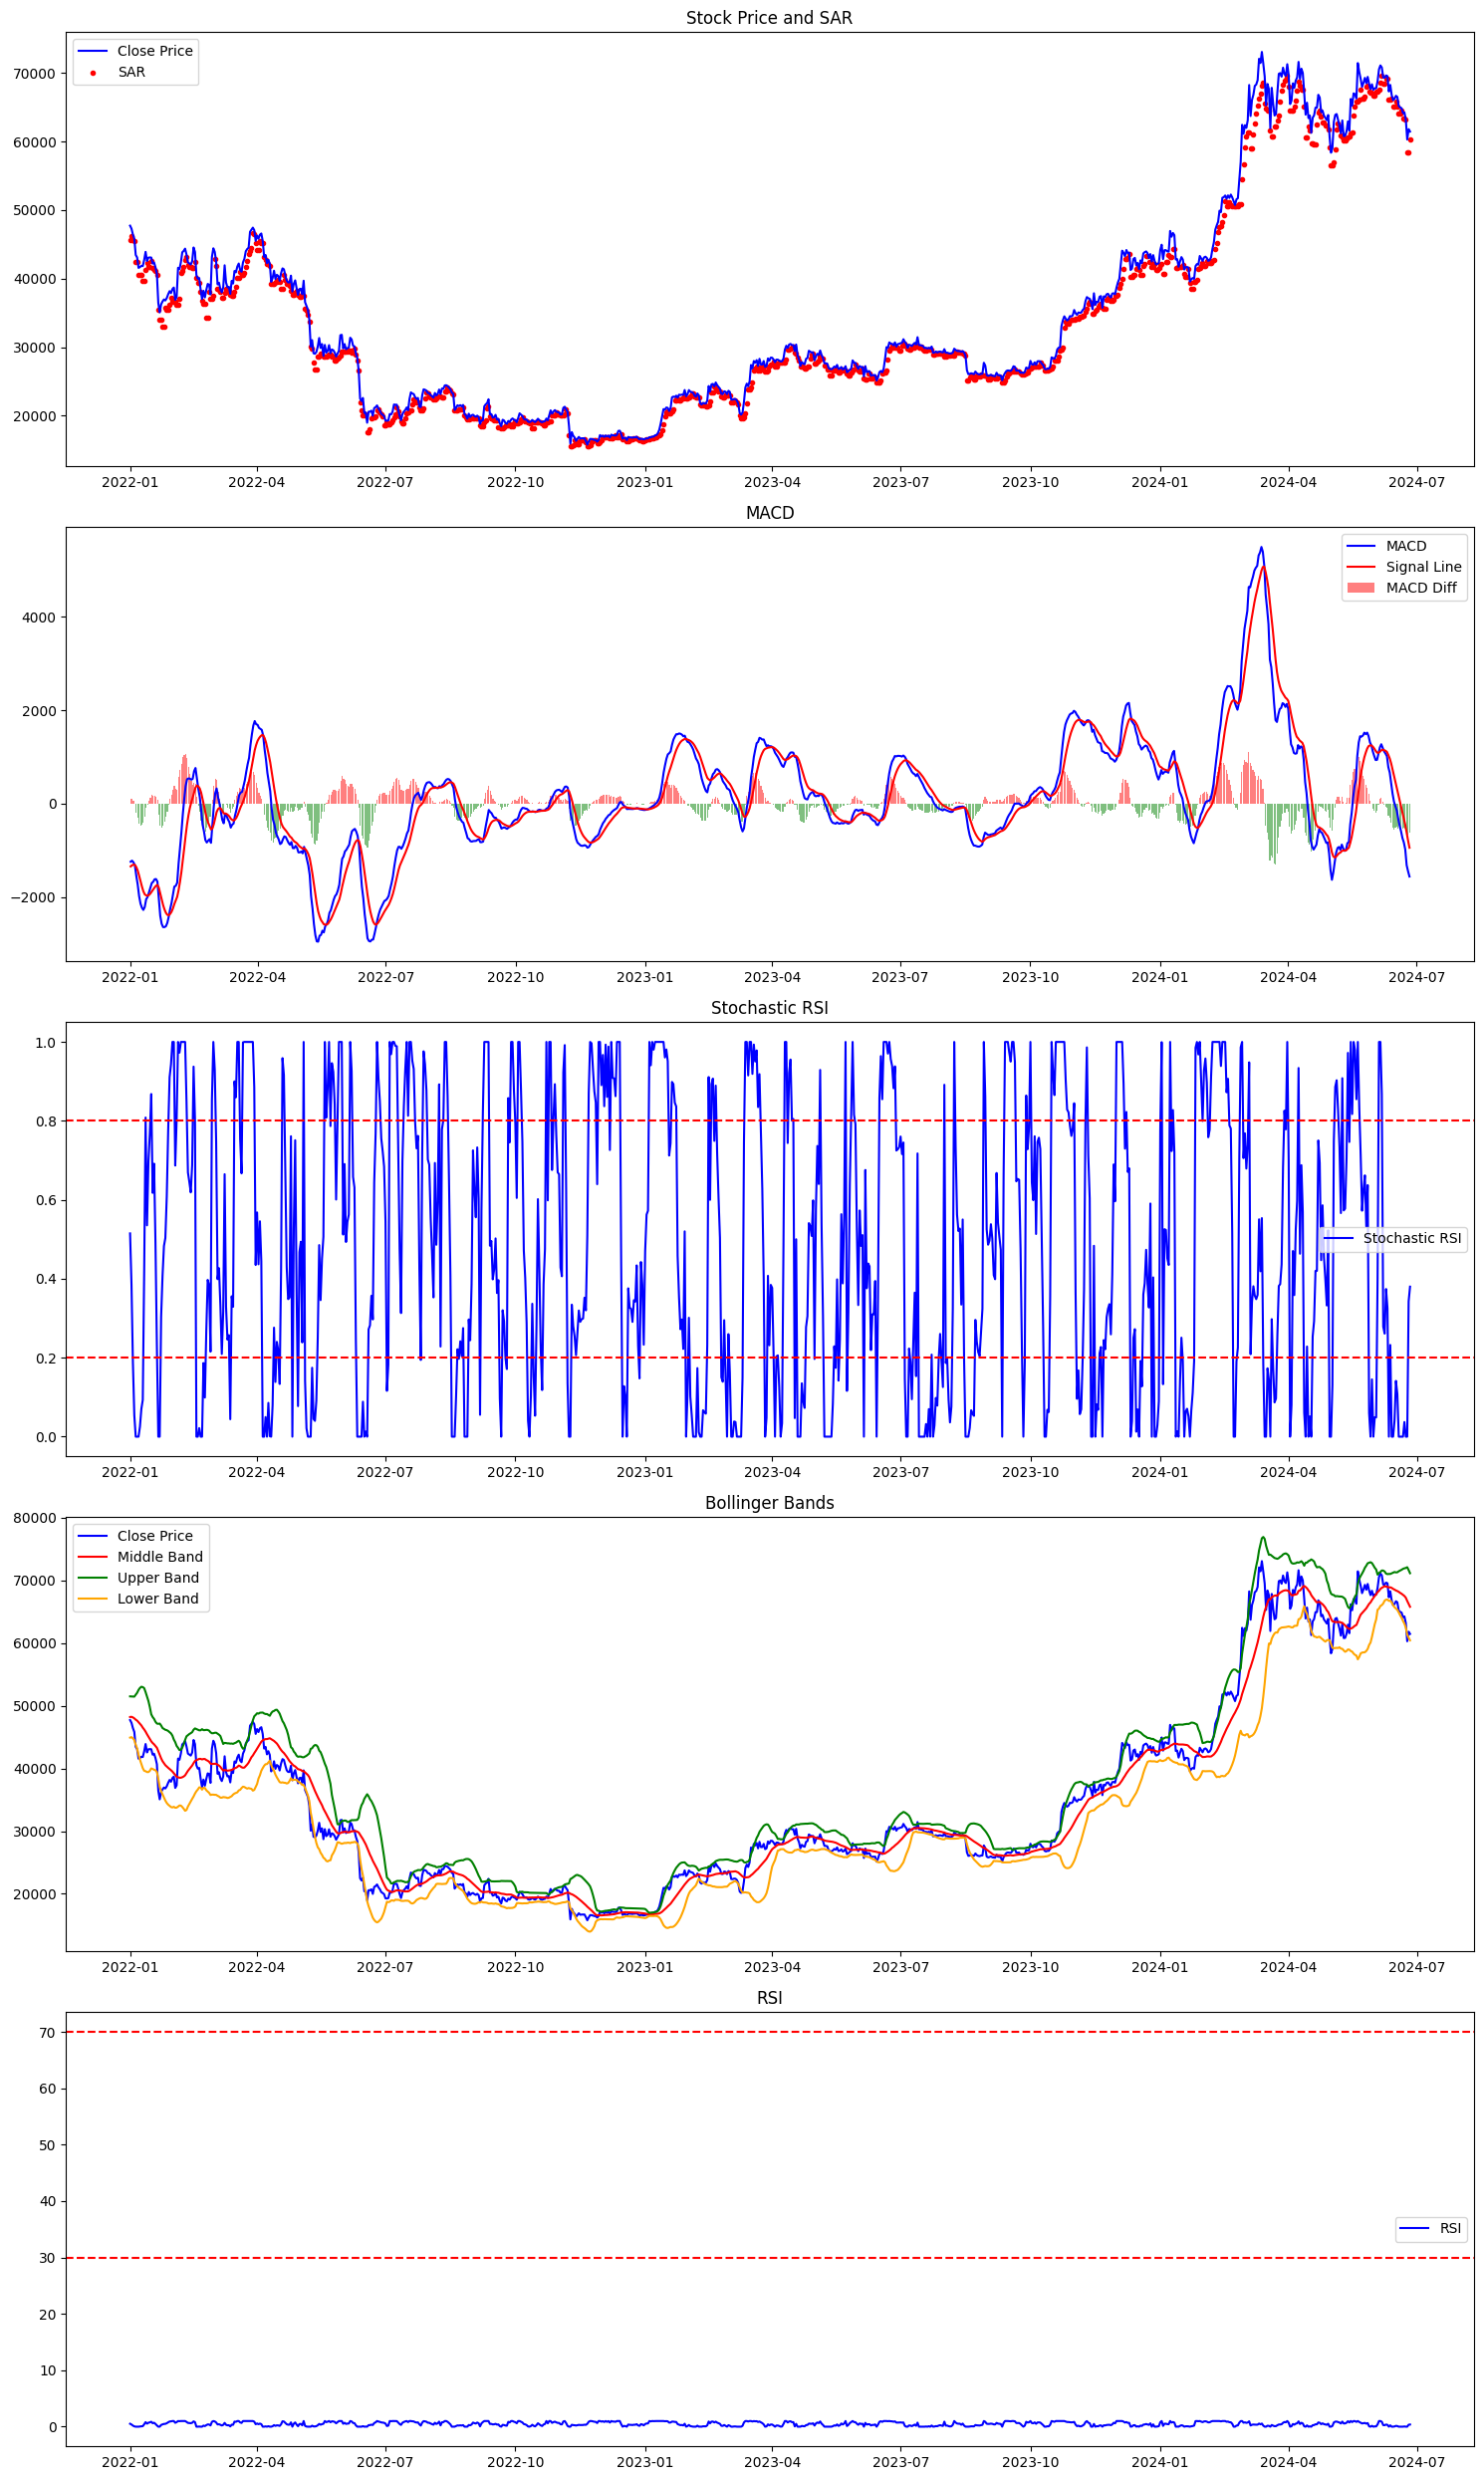

In [3]:
def plot_indicators(df):
    fig, axs = plt.subplots(5, 1, figsize=(15, 25))

    # 繪製股價圖和SAR
    axs[0].plot(df.index, df['close'], label='Close Price', color='blue')
    axs[0].scatter(df.index, df['SAR'], label='SAR', color='red', marker='.')
    axs[0].set_title('Stock Price and SAR')
    axs[0].legend()

    # 繪製MACD圖
    axs[1].plot(df.index, df['MACD'], label='MACD', color='blue')
    axs[1].plot(df.index, df['MACD_signal'], label='Signal Line', color='red')
    colors = ['red' if val > 0 else 'green' for val in df['MACD_diff']]
    axs[1].bar(df.index, df['MACD_diff'], color=colors, alpha=0.5, label='MACD Diff')
    # axs[1].bar(df.index, df['MACD_diff'], label='MACD Histogram', color='gray', alpha=0.5)
    axs[1].set_title('MACD')
    axs[1].legend()

    # 繪製Stochastic RSI圖
    axs[2].plot(df.index, df['Stoch_RSI'], label='Stochastic RSI', color='blue')
    axs[2].axhline(y=0.8, color='red', linestyle='--')
    axs[2].axhline(y=0.2, color='red', linestyle='--')
    axs[2].set_title('Stochastic RSI')
    axs[2].legend()

    # 繪製Bollinger Bands圖
    axs[3].plot(df.index, df['close'], label='Close Price', color='blue')
    axs[3].plot(df.index, df['Bollinger_Mid'], label='Middle Band', color='red')
    axs[3].plot(df.index, df['Bollinger_Upper'], label='Upper Band', color='green')
    axs[3].plot(df.index, df['Bollinger_Lower'], label='Lower Band', color='orange')
    axs[3].set_title('Bollinger Bands')
    axs[3].legend()

    # 繪製RSI圖
    axs[4].plot(df.index, df['Stoch_RSI'], label='RSI', color='blue')
    axs[4].axhline(y=70, color='red', linestyle='--')
    axs[4].axhline(y=30, color='red', linestyle='--')
    axs[4].set_title('RSI')
    axs[4].legend()

    plt.tight_layout()
    plt.show()
plot_indicators(df)

In [6]:
def backtest_strategy(df, use_macd=True, use_sar=True, use_rsi=True, fee=0.001, leverage=1):
    initial_balance = 10000  # 初始資金
    balance = initial_balance
    position = 0  # 持倉量
    trade_log = []

    wins = 0
    losses = 0

    for i in range(1, len(df)):
        prev_macd_diff = df['MACD_diff'].iloc[i - 1]
        curr_macd_diff = df['MACD_diff'].iloc[i]
        prev_sar = df['SAR'].iloc[i - 1]
        curr_sar = df['SAR'].iloc[i]
        curr_close = df['close'].iloc[i]
        curr_stoch_rsi = df['Stoch_RSI'].iloc[i]

        buy_signal = True
        sell_signal = True

        if use_macd:
            buy_signal = buy_signal and (prev_macd_diff <= 0 < curr_macd_diff)
            sell_signal = sell_signal and (prev_macd_diff >= 0 > curr_macd_diff)

        if use_sar:
            buy_signal = buy_signal and (curr_sar < curr_close)
            sell_signal = sell_signal and (curr_sar > curr_close)

        if use_rsi:
            buy_signal = buy_signal and (curr_stoch_rsi < 0.2)
            sell_signal = sell_signal and (curr_stoch_rsi > 0.8)

        if buy_signal and balance > 0:
            position = (balance / curr_close) * leverage * (1 - fee)  # 考慮手續費和槓桿
            balance = 0
            trade_log.append(('BUY', df.index[i], curr_close))

        elif sell_signal and position > 0:
            balance = (position * curr_close / leverage) * (1 - fee)  # 考慮手續費和槓桿
            position = 0
            trade_log.append(('SELL', df.index[i], curr_close))
            if curr_close > trade_log[-2][2]:  # 如果賣出價格高於買入價格，記錄一次勝利
                wins += 1
            else:
                losses += 1

    final_balance = balance + (position * df['close'].iloc[-1] / leverage)
    total_trades = wins + losses
    win_rate = wins / total_trades * 100 if total_trades > 0 else 0
    net_profit = (final_balance - initial_balance)
    return_rate = net_profit / initial_balance * 100
    
    result = {
        '初始金額': initial_balance,
        '最終金額': final_balance,
        '賺取金額': net_profit,
        '投報率(%)': return_rate,
        '勝率(%)': win_rate,
        '總交易次數': total_trades,
        '贏': wins,
        '輸': losses,
        'Trades': trade_log
    }

    return result


# 執行回測
result = backtest_strategy(df, use_macd, use_sar, use_rsi, fee, leverage)

# 顯示回測結果
for key, value in result.items():
    print(f"{key}: {value}")


初始金額: 10000
最終金額: 5364.06320988723
賺取金額: -4635.93679011277
投報率(%): -46.3593679011277
勝率(%): 34.375
總交易次數: 32
贏: 11
輸: 21
Trades: [('BUY', Timestamp('2022-01-14 00:00:00'), np.float64(43059.96)), ('SELL', Timestamp('2022-01-21 00:00:00'), np.float64(36445.31)), ('BUY', Timestamp('2022-01-29 00:00:00'), np.float64(38166.84)), ('SELL', Timestamp('2022-02-18 00:00:00'), np.float64(39974.44)), ('BUY', Timestamp('2022-02-28 00:00:00'), np.float64(43160.0)), ('SELL', Timestamp('2022-03-06 00:00:00'), np.float64(38420.81)), ('BUY', Timestamp('2022-03-16 00:00:00'), np.float64(41114.0)), ('SELL', Timestamp('2022-04-05 00:00:00'), np.float64(45497.55)), ('BUY', Timestamp('2022-05-04 00:00:00'), np.float64(39690.0)), ('SELL', Timestamp('2022-05-05 00:00:00'), np.float64(36552.97)), ('BUY', Timestamp('2022-05-20 00:00:00'), np.float64(29201.01)), ('SELL', Timestamp('2022-06-12 00:00:00'), np.float64(26574.53)), ('BUY', Timestamp('2022-06-25 00:00:00'), np.float64(21491.19)), ('SELL', Timestamp('20